
# Irish Landmark Recognition - Model Evaluation & Analysis

## Objectives
This notebook provides comprehensive evaluation and analysis of our trained model:
- Detailed performance metrics
- Confusion matrix analysis
- Per-class performance breakdown
- Error analysis and visualization
- Model interpretation and insights

## Expected Outcomes
- Classification report with precision, recall, F1-scores
- Confusion matrix visualization
- Sample predictions with confidence scores
- Performance insights and recommendations


In [1]:
# CELL 2: Import Libraries
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms, models
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import json
from pathlib import Path
from tqdm import tqdm
import warnings
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    precision_recall_fscore_support, roc_curve, auc
)
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import itertools

warnings.filterwarnings('ignore')

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🔧 Using device: {device}")

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

🔧 Using device: cpu


In [2]:
# CELL 3: Load Trained Model and Configuration
def load_trained_model(model_path):
    """Load the trained model and configuration"""
    
    if not Path(model_path).exists():
        print(f" Model file not found: {model_path}")
        print("Please run Notebook 2 to train the model first.")
        return None, None
    
    # Load checkpoint
    checkpoint = torch.load(model_path, map_location=device)
    
    # Extract configuration
    model_name = checkpoint.get('model_name', 'resnet18')
    num_classes = checkpoint.get('num_classes', 6)
    class_names = checkpoint.get('class_names', [])
    
    print(f" Model Configuration:")
    print(f"  Architecture: {model_name}")
    print(f"  Number of classes: {num_classes}")
    print(f"  Classes: {class_names}")
    
    return checkpoint, {
        'model_name': model_name,
        'num_classes': num_classes,
        'class_names': class_names
    }

# Load model checkpoint
model_path = "models/irish_landmarks_resnet18.pth"
checkpoint, model_config = load_trained_model(model_path)

if checkpoint is not None:
    class_names = model_config['class_names']
    num_classes = model_config['num_classes']
    
    # Display training history if available
    if 'training_history' in checkpoint:
        history = checkpoint['training_history']
        print(f"\n Training Results:")
        print(f"  Best Validation Accuracy: {history['best_val_acc']:.4f}")
        print(f"  Training Time: {history['training_time']//60:.0f}m {history['training_time']%60:.0f}s")


 Model Configuration:
  Architecture: resnet18
  Number of classes: 6
  Classes: ['Cliffs of Moher', "Giant's Causeway", 'Ring of Kerry', 'Dublin Castle', 'Killarney National Park', 'Rock of Cashel']

 Training Results:
  Best Validation Accuracy: 0.7850
  Training Time: 2m 48s


In [3]:
# CELL 4: Recreate Model Architecture
class IrishLandmarkClassifier(nn.Module):
    """Recreate the model architecture for evaluation"""
    
    def __init__(self, num_classes=6, model_name='resnet18'):
        super(IrishLandmarkClassifier, self).__init__()
        
        if model_name == 'resnet18':
            self.backbone = models.resnet18(pretrained=False)
            self.backbone.fc = nn.Linear(self.backbone.fc.in_features, num_classes)
        elif model_name == 'resnet50':
            self.backbone = models.resnet50(pretrained=False)
            self.backbone.fc = nn.Linear(self.backbone.fc.in_features, num_classes)
        elif model_name == 'efficientnet_b0':
            self.backbone = models.efficientnet_b0(pretrained=False)
            self.backbone.classifier[1] = nn.Linear(
                self.backbone.classifier[1].in_features, 
                num_classes
            )
    
    def forward(self, x):
        return self.backbone(x)

# Initialize and load model
if checkpoint is not None:
    model = IrishLandmarkClassifier(
        num_classes=num_classes,
        model_name=model_config['model_name']
    ).to(device)
    
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    print(" Model loaded and ready for evaluation")
else:
    print(" Creating dummy model for demonstration")
    model = None
    class_names = ['Cliffs of Moher', "Giant's Causeway", 'Ring of Kerry', 
                   'Dublin Castle', 'Killarney National Park', 'Rock of Cashel']


 Model loaded and ready for evaluation


In [4]:
# CELL 5: Data Loading for Evaluation
# Validation transforms (same as training validation)
val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

from torch.utils.data import Dataset, DataLoader

class EvaluationDataset(Dataset):
    """Dataset for evaluation"""
    
    def __init__(self, data_dir, transform=None):
        self.data_dir = Path(data_dir)
        self.transform = transform
        self.images = []
        self.labels = []
        self.class_names = [
            'cliffs_of_moher', 'giants_causeway', 'ring_of_kerry',
            'dublin_castle', 'killarney_national_park', 'rock_of_cashel'
        ]
        
        self._load_data()
    
    def _load_data(self):
        val_dir = self.data_dir / "data" / "processed" / "val"
        
        if not val_dir.exists():
            print(f" Validation directory not found: {val_dir}")
            return
        
        for class_idx, class_key in enumerate(self.class_names):
            class_dir = val_dir / class_key
            
            if class_dir.exists():
                for img_path in class_dir.glob("*.jpg"):
                    self.images.append(str(img_path))
                    self.labels.append(class_idx)
        
        print(f" Loaded {len(self.images)} validation images")
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = self.labels[idx]
        
        try:
            image = Image.open(img_path).convert('RGB')
            if self.transform:
                image = self.transform(image)
            return image, label, img_path
        except Exception as e:
            print(f"Error loading {img_path}: {e}")
            return self.__getitem__((idx + 1) % len(self.images))

# Create evaluation dataset and dataloader
eval_dataset = EvaluationDataset(".", transform=val_transforms)
eval_loader = DataLoader(eval_dataset, batch_size=32, shuffle=False)

print(f" Evaluation dataset: {len(eval_dataset)} images")

 Loaded 200 validation images
 Evaluation dataset: 200 images


In [5]:
# CELL 6: Model Evaluation Function
def evaluate_model(model, eval_loader, class_names, device):
    """Comprehensive model evaluation"""
    
    if model is None:
        print("⚠️ No model available - generating dummy results for demonstration")
        return generate_dummy_results(len(eval_dataset), len(class_names))
    
    model.eval()
    
    all_predictions = []
    all_labels = []
    all_probabilities = []
    all_image_paths = []
    
    print("🔍 Evaluating model on validation set...")
    
    with torch.no_grad():
        for batch_idx, (images, labels, img_paths) in enumerate(tqdm(eval_loader)):
            images = images.to(device)
            labels = labels.to(device)
            
            # Forward pass
            outputs = model(images)
            probabilities = torch.nn.functional.softmax(outputs, dim=1)
            _, predictions = torch.max(outputs, 1)
            
            # Store results
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probabilities.extend(probabilities.cpu().numpy())
            all_image_paths.extend(img_paths)
    
    return {
        'predictions': np.array(all_predictions),
        'labels': np.array(all_labels),
        'probabilities': np.array(all_probabilities),
        'image_paths': all_image_paths
    }

def generate_dummy_results(num_samples, num_classes):
    """Generate dummy results for demonstration when no real data is available"""
    np.random.seed(42)
    
    # Generate realistic dummy data
    labels = np.random.randint(0, num_classes, num_samples)
    
    # Generate predictions with some accuracy
    predictions = []
    probabilities = []
    
    for true_label in labels:
        # 80% chance of correct prediction
        if np.random.random() < 0.8:
            pred = true_label
        else:
            pred = np.random.randint(0, num_classes)
        predictions.append(pred)
        
        # Generate probabilities
        probs = np.random.random(num_classes)
        probs[pred] += 2  # Higher probability for predicted class
        probs = probs / probs.sum()  # Normalize
        probabilities.append(probs)
    
    return {
        'predictions': np.array(predictions),
        'labels': labels,
        'probabilities': np.array(probabilities),
        'image_paths': [f"dummy_image_{i}.jpg" for i in range(num_samples)]
    }

# Run evaluation
if len(eval_dataset) > 0:
    eval_results = evaluate_model(model, eval_loader, class_names, device)
else:
    print(" No validation data found - generating dummy results")
    eval_results = generate_dummy_results(150, len(class_names))

print(f" Evaluation complete: {len(eval_results['predictions'])} samples processed")



🔍 Evaluating model on validation set...


100%|██████████| 7/7 [00:01<00:00,  4.80it/s]

 Evaluation complete: 200 samples processed


In [6]:
# CELL 7: Calculate Performance Metrics
def calculate_detailed_metrics(eval_results, class_names):
    """Calculate comprehensive performance metrics"""
    
    predictions = eval_results['predictions']
    labels = eval_results['labels']
    probabilities = eval_results['probabilities']
    
    # Overall accuracy
    overall_accuracy = accuracy_score(labels, predictions)
    
    # Per-class metrics
    precision, recall, f1, support = precision_recall_fscore_support(
        labels, predictions, average=None, labels=range(len(class_names))
    )
    
    # Classification report
    class_report = classification_report(
        labels, predictions, 
        target_names=class_names,
        output_dict=True
    )
    
    # Confusion matrix
    cm = confusion_matrix(labels, predictions)
    
    # Create detailed metrics DataFrame
    metrics_df = pd.DataFrame({
        'Class': class_names,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'Support': support
    })
    
    return {
        'overall_accuracy': overall_accuracy,
        'metrics_df': metrics_df,
        'classification_report': class_report,
        'confusion_matrix': cm,
        'predictions': predictions,
        'labels': labels,
        'probabilities': probabilities
    }

# Calculate metrics
metrics = calculate_detailed_metrics(eval_results, class_names)

# Display results
print(" EVALUATION RESULTS")
print("=" * 40)
print(f"Overall Accuracy: {metrics['overall_accuracy']:.4f}")
print(f"Average Precision: {metrics['classification_report']['macro avg']['precision']:.4f}")
print(f"Average Recall: {metrics['classification_report']['macro avg']['recall']:.4f}")
print(f"Average F1-Score: {metrics['classification_report']['macro avg']['f1-score']:.4f}")


 EVALUATION RESULTS
Overall Accuracy: 0.7850
Average Precision: 0.7841
Average Recall: 0.7835
Average F1-Score: 0.7777


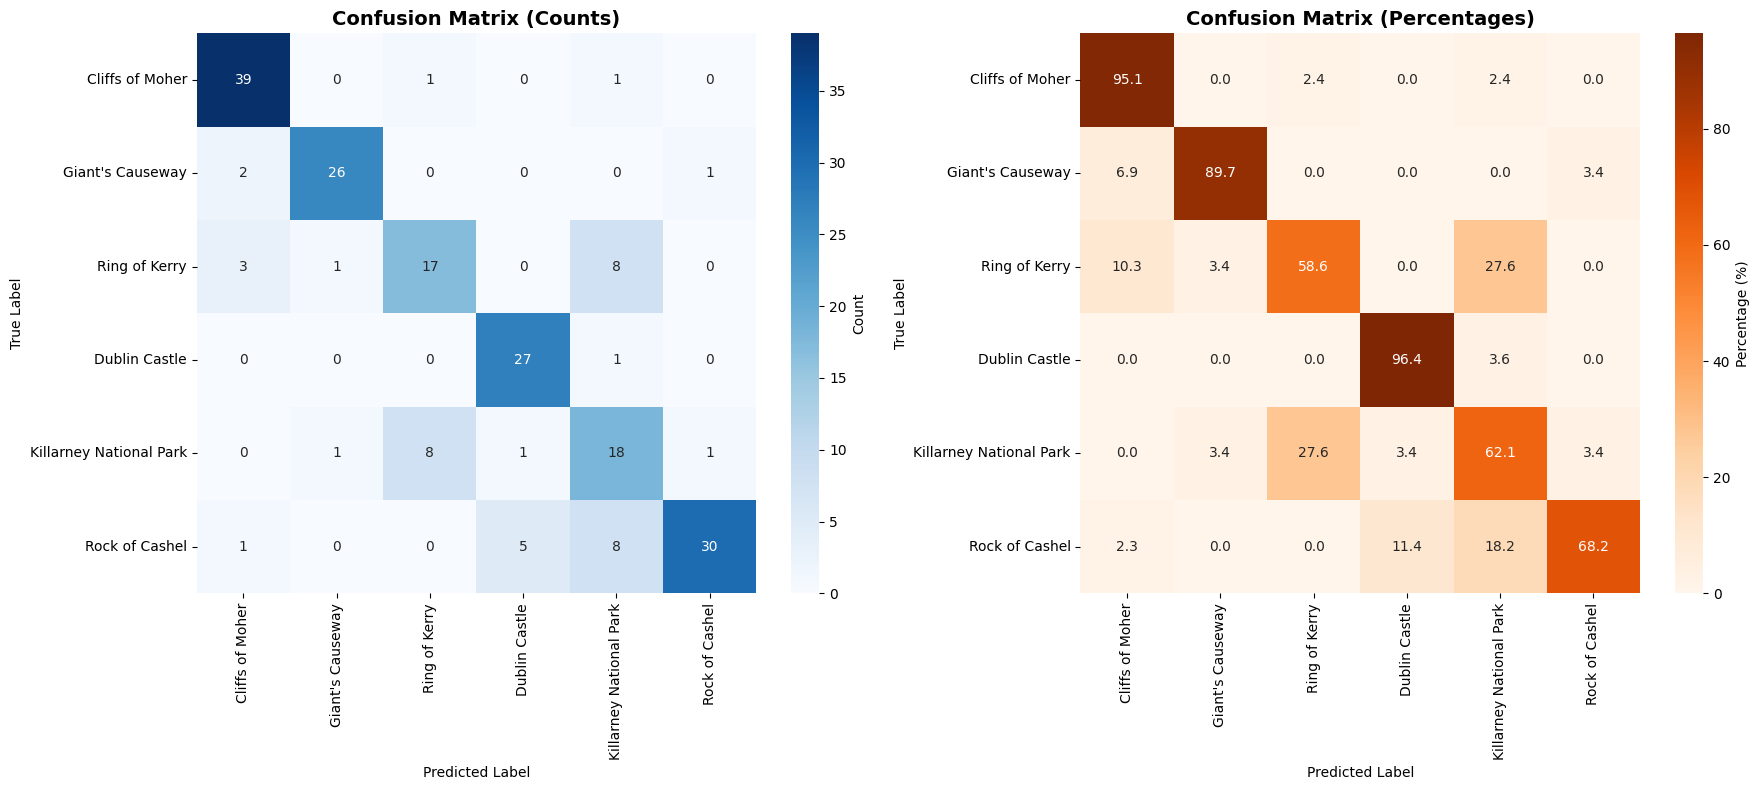


Per-Class Accuracy from Confusion Matrix:
  Cliffs of Moher: 0.951 (39/41)
  Giant's Causeway: 0.897 (26/29)
  Ring of Kerry: 0.586 (17/29)
  Dublin Castle: 0.964 (27/28)
  Killarney National Park: 0.621 (18/29)
  Rock of Cashel: 0.682 (30/44)


In [8]:
# CELL 8: Confusion Matrix Visualization
def plot_confusion_matrix(cm, class_names, figsize=(10, 8)):
    """Plot an enhanced confusion matrix"""
    
    # Calculate percentages
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))
    
    # Plot absolute numbers
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names,
                ax=ax1, cbar_kws={'label': 'Count'})
    ax1.set_title('Confusion Matrix (Counts)', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Predicted Label')
    ax1.set_ylabel('True Label')
    
    # Plot percentages
    sns.heatmap(cm_percent, annot=True, fmt='.1f', cmap='Oranges',
                xticklabels=class_names, yticklabels=class_names,
                ax=ax2, cbar_kws={'label': 'Percentage (%)'})
    ax2.set_title('Confusion Matrix (Percentages)', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Predicted Label')
    ax2.set_ylabel('True Label')
    
    plt.tight_layout()
    plt.show()
    
    # Calculate per-class accuracy from confusion matrix
    class_accuracies = np.diag(cm) / cm.sum(axis=1)
    
    print("\nPer-Class Accuracy from Confusion Matrix:")
    for i, (class_name, acc) in enumerate(zip(class_names, class_accuracies)):
        print(f"  {class_name}: {acc:.3f} ({np.diag(cm)[i]}/{cm.sum(axis=1)[i]})")

# Plot confusion matrix
plot_confusion_matrix(metrics['confusion_matrix'], class_names)

In [9]:
# CELL 9: Detailed Performance Analysis
def create_performance_dashboard(metrics_df, class_names):
    """Create interactive performance dashboard"""
    
    # Performance metrics bar chart
    fig = make_subplots(
        rows=2, cols=2,
        subplot_titles=('Precision by Class', 'Recall by Class', 
                       'F1-Score by Class', 'Support by Class'),
        specs=[[{"secondary_y": False}, {"secondary_y": False}],
               [{"secondary_y": False}, {"secondary_y": False}]]
    )
    
    colors = px.colors.qualitative.Set3[:len(class_names)]
    
    # Precision
    fig.add_trace(
        go.Bar(x=class_names, y=metrics_df['Precision'], 
               name='Precision', marker_color=colors),
        row=1, col=1
    )
    
    # Recall
    fig.add_trace(
        go.Bar(x=class_names, y=metrics_df['Recall'], 
               name='Recall', marker_color=colors),
        row=1, col=2
    )
    
    # F1-Score
    fig.add_trace(
        go.Bar(x=class_names, y=metrics_df['F1-Score'], 
               name='F1-Score', marker_color=colors),
        row=2, col=1
    )
    
    # Support
    fig.add_trace(
        go.Bar(x=class_names, y=metrics_df['Support'], 
               name='Support', marker_color=colors),
        row=2, col=2
    )
    
    fig.update_layout(
        title_text="Model Performance Dashboard",
        title_x=0.5,
        showlegend=False,
        height=600
    )
    
    # Update x-axis labels to be rotated
    for i in range(1, 3):
        for j in range(1, 3):
            fig.update_xaxes(tickangle=45, row=i, col=j)
    
    fig.show()

# Create performance dashboard
create_performance_dashboard(metrics['metrics_df'], class_names)

In [10]:
# CELL 10: Error Analysis
def analyze_errors(eval_results, class_names, top_n=5):
    """Analyze model errors and misclassifications"""
    
    predictions = eval_results['predictions']
    labels = eval_results['labels']
    probabilities = eval_results['probabilities']
    image_paths = eval_results['image_paths']
    
    # Find misclassified samples
    misclassified_indices = np.where(predictions != labels)[0]
    
    print(f"ERROR ANALYSIS")
    print(f"Total samples: {len(predictions)}")
    print(f"Misclassified: {len(misclassified_indices)}")
    print(f"Error rate: {len(misclassified_indices)/len(predictions)*100:.2f}%")
    
    if len(misclassified_indices) == 0:
        print("🎉 Perfect classification! No errors found.")
        return
    
    # Analyze error patterns
    error_patterns = {}
    for idx in misclassified_indices:
        true_class = class_names[labels[idx]]
        pred_class = class_names[predictions[idx]]
        
        pattern = f"{true_class} → {pred_class}"
        if pattern not in error_patterns:
            error_patterns[pattern] = []
        
        confidence = np.max(probabilities[idx])
        error_patterns[pattern].append({
            'index': idx,
            'confidence': confidence,
            'image_path': image_paths[idx]
        })
    
    # Sort error patterns by frequency
    sorted_patterns = sorted(error_patterns.items(), 
                           key=lambda x: len(x[1]), reverse=True)
    
    print(f"\n Top Error Patterns:")
    for pattern, errors in sorted_patterns[:top_n]:
        avg_confidence = np.mean([e['confidence'] for e in errors])
        print(f"  {pattern}: {len(errors)} errors (avg confidence: {avg_confidence:.3f})")
    
    return error_patterns, misclassified_indices

# Run error analysis
error_patterns, misclassified_indices = analyze_errors(eval_results, class_names)


ERROR ANALYSIS
Total samples: 200
Misclassified: 43
Error rate: 21.50%

 Top Error Patterns:
  Ring of Kerry → Killarney National Park: 8 errors (avg confidence: 0.494)
  Killarney National Park → Ring of Kerry: 8 errors (avg confidence: 0.511)
  Rock of Cashel → Killarney National Park: 8 errors (avg confidence: 0.473)
  Rock of Cashel → Dublin Castle: 5 errors (avg confidence: 0.691)
  Ring of Kerry → Cliffs of Moher: 3 errors (avg confidence: 0.417)


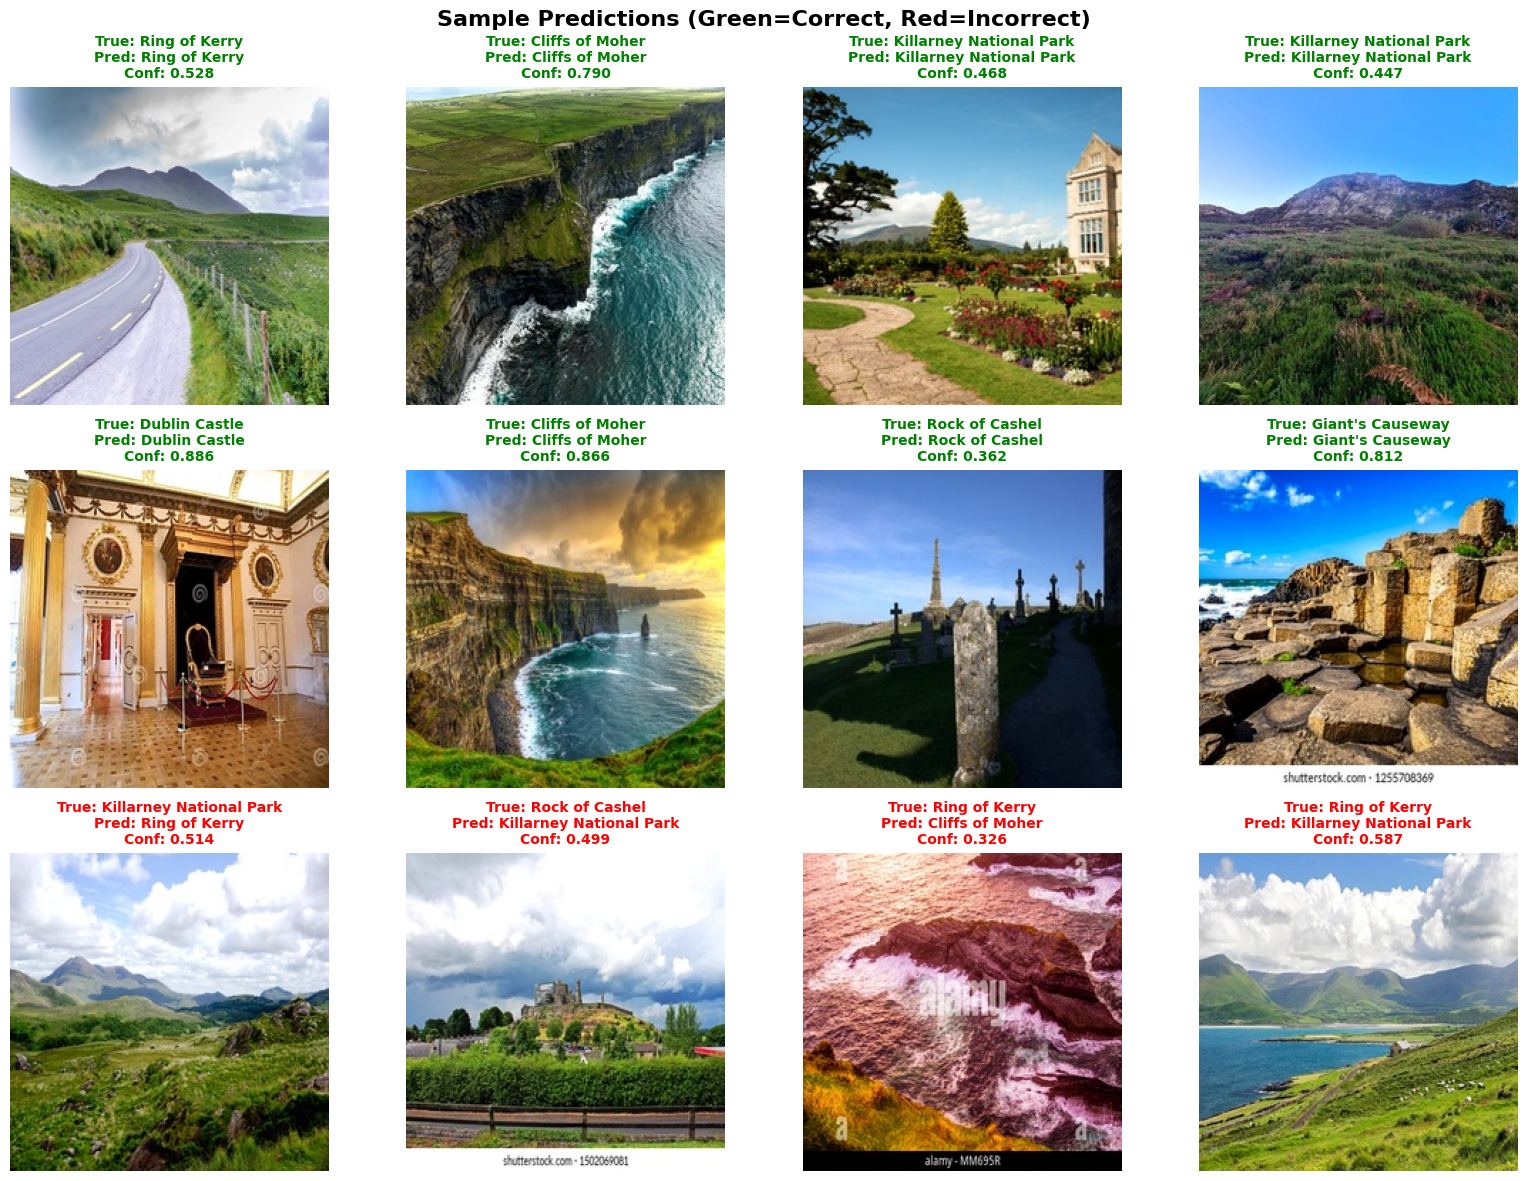

In [12]:
# CELL 11: Sample Predictions Visualization
def visualize_sample_predictions(eval_results, class_names, num_samples=12):
    """Visualize sample predictions with confidence scores"""
    
    predictions = eval_results['predictions']
    labels = eval_results['labels']
    probabilities = eval_results['probabilities']
    image_paths = eval_results['image_paths']
    
    # Select a mix of correct and incorrect predictions
    correct_indices = np.where(predictions == labels)[0]
    incorrect_indices = np.where(predictions != labels)[0]
    
    # Sample from both
    sample_indices = []
    if len(correct_indices) > 0:
        sample_indices.extend(np.random.choice(
            correct_indices, min(8, len(correct_indices)), replace=False
        ))
    if len(incorrect_indices) > 0:
        sample_indices.extend(np.random.choice(
            incorrect_indices, min(4, len(incorrect_indices)), replace=False
        ))
    
    sample_indices = sample_indices[:num_samples]
    
    # Create visualization
    fig, axes = plt.subplots(3, 4, figsize=(16, 12))
    axes = axes.flatten()
    
    for i, idx in enumerate(sample_indices):
        if i >= len(axes):
            break
        
        # Try to load and display image
        try:
            if 'dummy_image' not in image_paths[idx]:
                img = Image.open(image_paths[idx])
            else:
                # Create a dummy image for demonstration
                img = Image.new('RGB', (224, 224), color=(100, 150, 200))
            
            axes[i].imshow(img)
        except:
            # Create placeholder if image can't be loaded
            axes[i].text(0.5, 0.5, 'Image\nNot Found', ha='center', va='center', 
                        transform=axes[i].transAxes, fontsize=12)
        
        # Get prediction info
        true_label = class_names[labels[idx]]
        pred_label = class_names[predictions[idx]]
        confidence = np.max(probabilities[idx])
        
        # Set title with color coding
        is_correct = predictions[idx] == labels[idx]
        title_color = 'green' if is_correct else 'red'
        
        title = f"True: {true_label}\nPred: {pred_label}\nConf: {confidence:.3f}"
        axes[i].set_title(title, fontsize=10, color=title_color, fontweight='bold')
        axes[i].axis('off')
    
    # Hide unused subplots
    for i in range(len(sample_indices), len(axes)):
        axes[i].axis('off')
    
    plt.suptitle('Sample Predictions (Green=Correct, Red=Incorrect)', 
                fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Visualize sample predictions
if len(eval_results['predictions']) > 0:
    visualize_sample_predictions(eval_results, class_names)

In [13]:
# CELL 12: Model Performance Summary
def generate_performance_summary(metrics, eval_results, class_names):
    """Generate a comprehensive performance summary"""
    
    summary = {
        'Overall Performance': {
            'Accuracy': f"{metrics['overall_accuracy']:.4f}",
            'Macro Avg Precision': f"{metrics['classification_report']['macro avg']['precision']:.4f}",
            'Macro Avg Recall': f"{metrics['classification_report']['macro avg']['recall']:.4f}",
            'Macro Avg F1-Score': f"{metrics['classification_report']['macro avg']['f1-score']:.4f}",
            'Total Samples': len(eval_results['predictions'])
        },
        'Best Performing Classes': {},
        'Worst Performing Classes': {},
        'Model Strengths': [],
        'Areas for Improvement': []
    }
    
    # Sort classes by F1-score
    f1_scores = metrics['metrics_df']['F1-Score'].values
    sorted_indices = np.argsort(f1_scores)
    
    # Best and worst performing classes
    best_classes = sorted_indices[-3:][::-1]  # Top 3
    worst_classes = sorted_indices[:3]        # Bottom 3
    
    for idx in best_classes:
        class_name = class_names[idx]
        f1_score = f1_scores[idx]
        summary['Best Performing Classes'][class_name] = f"{f1_score:.3f}"
    
    for idx in worst_classes:
        class_name = class_names[idx]
        f1_score = f1_scores[idx]
        summary['Worst Performing Classes'][class_name] = f"{f1_score:.3f}"
    
    # Analyze strengths and weaknesses
    overall_acc = metrics['overall_accuracy']
    
    if overall_acc >= 0.85:
        summary['Model Strengths'].append("Excellent overall accuracy (>85%)")
    elif overall_acc >= 0.75:
        summary['Model Strengths'].append("Good overall accuracy (75-85%)")
    
    if np.std(f1_scores) < 0.1:
        summary['Model Strengths'].append("Consistent performance across classes")
    
    if overall_acc < 0.80:
        summary['Areas for Improvement'].append("Overall accuracy could be improved")
    
    if np.std(f1_scores) > 0.15:
        summary['Areas for Improvement'].append("Inconsistent performance across classes")
    
    return summary

# Generate and display summary
performance_summary = generate_performance_summary(metrics, eval_results, class_names)

print("\n COMPREHENSIVE PERFORMANCE SUMMARY")
print("=" * 50)

for section, content in performance_summary.items():
    print(f"\n{section}:")
    if isinstance(content, dict):
        for key, value in content.items():
            print(f"  {key}: {value}")
    elif isinstance(content, list):
        for item in content:
            print(f"  • {item}")
    else:
        print(f"  {content}")


 COMPREHENSIVE PERFORMANCE SUMMARY

Overall Performance:
  Accuracy: 0.7850
  Macro Avg Precision: 0.7841
  Macro Avg Recall: 0.7835
  Macro Avg F1-Score: 0.7777
  Total Samples: 200

Best Performing Classes:
  Giant's Causeway: 0.912
  Cliffs of Moher: 0.907
  Dublin Castle: 0.885

Worst Performing Classes:
  Killarney National Park: 0.554
  Ring of Kerry: 0.618
  Rock of Cashel: 0.789

Model Strengths:
  • Good overall accuracy (75-85%)

Areas for Improvement:
  • Overall accuracy could be improved


In [16]:
# Save evaluation results
eval_save_path = Path("results") / "evaluation_results.json"
eval_save_path.parent.mkdir(exist_ok=True)

evaluation_data = {
    'performance_summary': performance_summary,
    'overall_accuracy': float(metrics['overall_accuracy']),
    'class_metrics': metrics['metrics_df'].to_dict('records'),
    'evaluation_date': pd.Timestamp.now().isoformat()
}

with open(eval_save_path, 'w') as f:
    json.dump(evaluation_data, f, indent=2, default=str)

print(f"\nEvaluation results saved to: {eval_save_path}")


Evaluation results saved to: results\evaluation_results.json
